# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [253]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [254]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [255]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

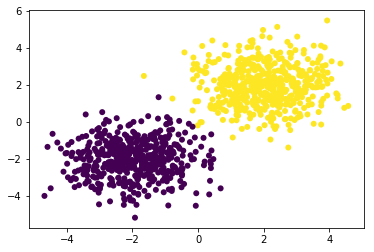

In [317]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')


Define a **logistic regression** for debugging. 

In [318]:
net = Sequential()

net.add(Linear(X.shape[1],6))
net.add(ReLU())
net.add(Linear(6,2))
net.add(LogSigmoid())


'''net.add(Linear(2, 20))
net.add(SoftPlus())
net.add(Linear(20, 2))
net.add(SoftMax())
'''

criterion = ClassNLLCriterionUnstable() #ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 6
ReLU
Linear 6 -> 2
LogSigmoid



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [319]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 5
batch_size = 128

In [320]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

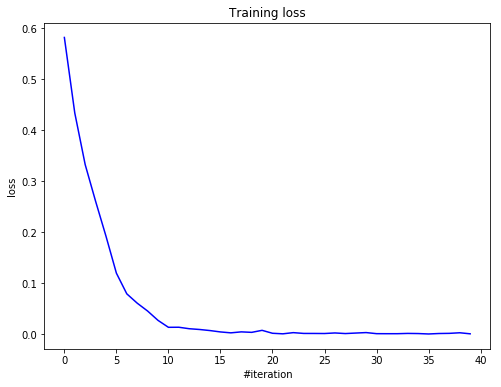

Current loss: 0.000585


In [321]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        #print(predictions)
        # Backward
        dp = criterion.backward(predictions, y_batch)
        
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)
        
    predictions = net.forward(X )
    predictions = predictions
    print(predictions)
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)   

    
 

In [327]:
predictions = net.forward(X)
print('accuracy = ', accuracy_score(np.argmax(predictions, axis=1), np.argmax(Y, axis=1) ))

accuracy =  0.996


# Utils

In [87]:
from sklearn.metrics import accuracy_score
def fit(X, Y, netw, criterion = None, is_accr=True, n_epoch = 20, batch_size = 128, optimizer_config= {'learning_rate' : 1e-1, 'momentum': 0.9} ):
    if criterion == None:
        criterion = ClassNLLCriterionUnstable()
    loss_history = []
    accr_history = []
    optimizer_state = {}
    
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            netw.zeroGradParameters()

            # Forward
            predictions = netw.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            
            # Backward
            dp = criterion.backward(predictions, y_batch)

            netw.backward(x_batch, dp)

            # Update weights
            sgd_momentum(netw.getParameters(), 
                         netw.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
            if is_accr:
                #print((predictions.shape), y_batch.shape)
                accr_history.append(accuracy_score(np.round(predictions), y_batch))
            loss_history.append(loss)
    return accr_history, loss_history
    

In [88]:
def visulate(history, name="History"):
    plt.title(name)
    plt.plot(history)
    plt.show()

(Not my)

In [40]:
import struct
import sys

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)

# Synthetic

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


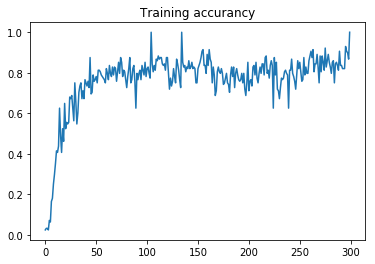

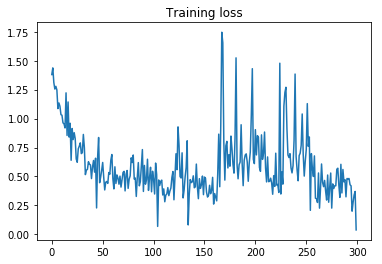

0.815

In [239]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X_gen, Y_gen = make_classification(n_classes=4, n_clusters_per_class=2, n_informative=10, n_samples=2000)
X_train, X_test, y_train, y_test = train_test_split(X_gen, Y_gen, test_size=.1)
net = Sequential()
criterion = ClassNLLCriterionUnstable()
net.add(Linear(X_train.shape[1], 40))
net.add(ReLU())
net.add(Linear(40, 4))
net.add(SoftMax())
y_train = y_train.reshape(-1, 1)
onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train)
accr_history, loss_history = fit(X_train, y_train, net, criterion, True)

plt.title("Training accurancy")
plt.plot(accr_history)
plt.show()
plt.title("Training loss")
plt.plot(loss_history)
plt.show()

predictions = net.forward(X_test )
predictions = np.round(predictions)

#y_test = onehot_encoder.fit_transform(y_test.reshape(-1, 1))
#loss = criterion.forward(predictions, y_test)
#print("loss ", loss)

accuracy_score(onehot_encoder.inverse_transform(predictions).reshape(-1), y_test )
#accuracy_score(np.argmax(predictions, axis=1), y_test )

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [231]:
import os
from sklearn.datasets import fetch_mldata

from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


# Fetch MNIST dataset and create a local copy.
"""if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)"""



X = read_idx('./mnist/train-images.idx3-ubyte')/ 255# from http://yann.lecun.com/exdb/mnist/
y = read_idx('./mnist/train-labels.idx1-ubyte')

X = X.reshape(-1, 28*28)# linearize
y = y.reshape(-1, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


One-hot encode the labels first.

In [58]:
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(60000, 10)


# SoftMax

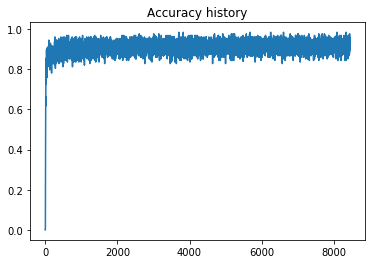

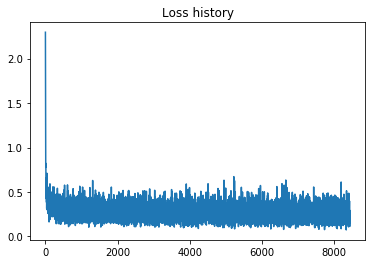

Accuracy = 0.9068333333333334
Loss  = 0.2916708607800947


In [166]:
net = Sequential()
net.add(Linear(X_train.shape[1], 10))
net.add(SoftMax())

criterion = ClassNLLCriterionUnstable()

acc_history, loss_history = fit(X_train, y_train, net, criterion)

visulate(acc_history, "Accuracy history")
visulate(loss_history, "Loss history")

net.evaluate()
predictions_inormal = net.forward(X_test)
predictions = np.round(predictions_inormal)
accuracy = accuracy_score(predictions, y_test)
print("Accuracy =", accuracy)
print("Loss  =", criterion.forward(predictions_inormal, y_test))

# Relu+SoftMax

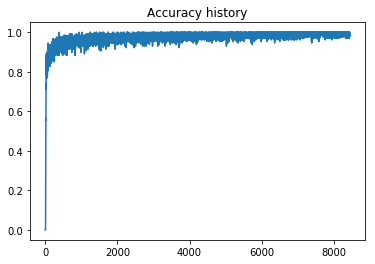

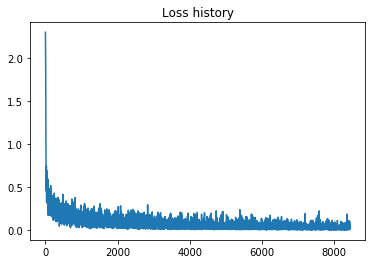

Accuracy = 0.9655
Loss  = 0.14064019102673184


In [123]:
net = Sequential()
net.add(Linear(X_train.shape[1], 40))
net.add(ReLU())
net.add(Linear(40, 10))
net.add(SoftMax())

criterion = ClassNLLCriterionUnstable()

acc_history, loss_history = fit(X_train, y_train, net, criterion, 3)

visulate(acc_history, "Accuracy history")
visulate(loss_history, "Loss history")

net.evaluate()
predictions_inormal = net.forward(X_test)
predictions = np.round(predictions_inormal)
accuracy = accuracy_score(predictions, y_test)
print("Accuracy =", accuracy)
print("Loss  =", criterion.forward(predictions_inormal, y_test))

# Relu+Dropout+SoftMax

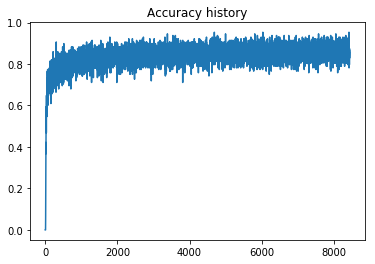

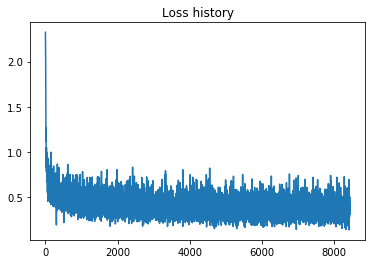

Accuracy = 0.9371666666666667
Loss  = 0.1848777606904072


In [185]:
net = Sequential()
net.add(Linear(X_train.shape[1], 40))
net.add(ReLU())
net.add(Dropout(0.5))
net.add(Linear(40, 10))
net.add(SoftMax())

criterion = ClassNLLCriterionUnstable()

acc_history, loss_history = fit(X_train, y_train, net, criterion, 3)

visulate(acc_history, "Accuracy history")
visulate(loss_history, "Loss history")

net.evaluate()
predictions_inormal = net.forward(X_test)
predictions = np.round(predictions_inormal)
accuracy = accuracy_score(predictions, y_test)
print("Accuracy =", accuracy)
print("Loss  =", criterion.forward(predictions_inormal, y_test))

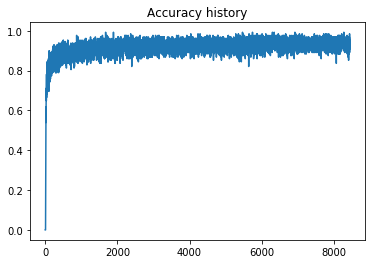

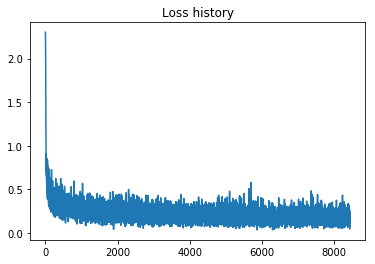

Accuracy = 0.9608333333333333
Loss  = 0.13701994907040244


In [193]:
net = Sequential()
net.add(Linear(X_train.shape[1], 40))
net.add(ReLU())
net.add(Dropout(0.3))
net.add(Linear(40, 10))
net.add(SoftMax())

criterion = ClassNLLCriterionUnstable()

acc_history, loss_history = fit(X_train, y_train, net, criterion)

visulate(acc_history, "Accuracy history")
visulate(loss_history, "Loss history")

net.evaluate()
predictions_inormal = net.forward(X_test)
predictions = np.round(predictions_inormal)
accuracy = accuracy_score(predictions, y_test)
print("Accuracy =", accuracy)
print("Loss  =", criterion.forward(predictions_inormal, y_test))

# Relu+Relu+SoftMax

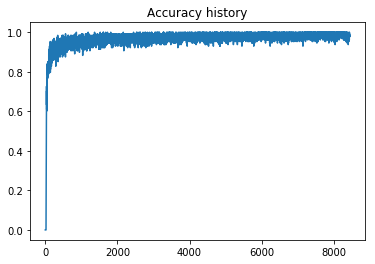

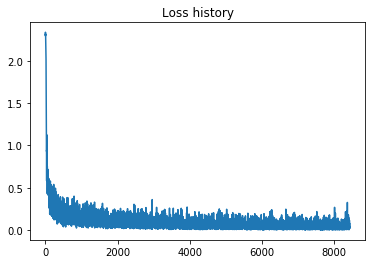

Accuracy = 0.9676666666666667
Loss  = 1.1167537701021129


In [97]:
net = Sequential()
net.add(Linear(X_train.shape[1], 40))
net.add(ReLU())
net.add(Linear(40, 20))
net.add(ReLU())
net.add(Linear(20, 10))
net.add(SoftMax())

criterion = ClassNLLCriterionUnstable()

acc_history, loss_history = fit(X_train, y_train, net, criterion, 3)

visulate(acc_history, "Accuracy history")
visulate(loss_history, "Loss history")

net.evaluate()
predictions_inormal = net.forward(X_test)
predictions = np.round(predictions_inormal)
accuracy = accuracy_score(predictions, y_test)
print("Accuracy =", accuracy)
print("Loss  =", criterion.forward(predictions_inormal, y_test))


+Droput

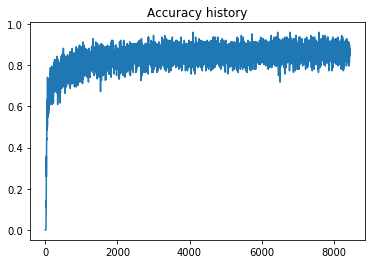

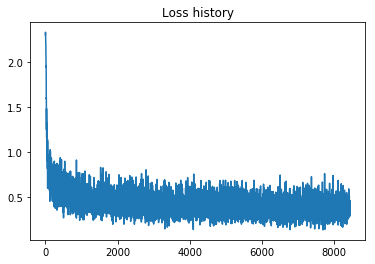

Accuracy = 0.9165
Loss  = 0.21573904593868162


In [192]:
net = Sequential()
net.add(Linear(X_train.shape[1], 40))
net.add(ReLU())
net.add(Dropout(0.5))
net.add(Linear(40, 20))
net.add(ReLU())
net.add(Linear(20, 10))
net.add(SoftMax())

criterion = ClassNLLCriterionUnstable()

acc_history, loss_history = fit(X_train, y_train, net, criterion)

visulate(acc_history, "Accuracy history")
visulate(loss_history, "Loss history")

net.evaluate()
predictions_inormal = net.forward(X_test)
predictions = np.round(predictions_inormal)
accuracy = accuracy_score(predictions, y_test)
print("Accuracy =", accuracy)
print("Loss  =", criterion.forward(predictions_inormal, y_test))

#  LogSigmoid + SoftMax

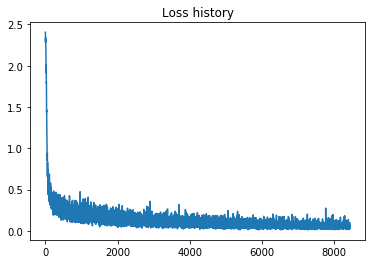

Accuracy = 0.967
Loss  = 0.10522044252922821


In [195]:
net = Sequential()
net.add(Linear(X_train.shape[1], 40))
net.add(LogSigmoid())
net.add(Linear(40, 10))
net.add(SoftMax())

criterion = ClassNLLCriterionUnstable()

acc_history, loss_history = fit(X_train, y_train, net, criterion, False)

#visulate(acc_history, "Accuracy history")
visulate(loss_history, "Loss history")

net.evaluate()
predictions_inormal_sigm = net.forward(X_test)
predictions_sigm  = np.round(predictions_inormal_sigm )
accuracy = accuracy_score(predictions_sigm, y_test)
print("Accuracy =", accuracy)
print("Loss  =", criterion.forward(predictions_inormal_sigm, y_test))

In [208]:
predictions_sigm

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# LeakyReLU + SoftPlus + SoftMax

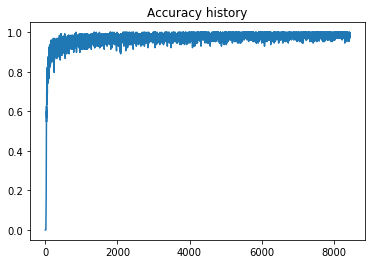

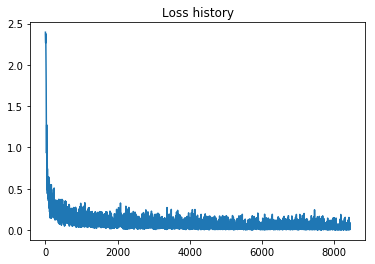

Accuracy = 0.9661666666666666
Loss  = 0.15831155542552702


In [172]:
net = Sequential()
net.add(Linear(X_train.shape[1], 40))
net.add(LeakyReLU())
net.add(Linear(40, 20))
net.add(SoftPlus())
net.add(Linear(20, 10))
net.add(SoftMax())

criterion = ClassNLLCriterionUnstable()

acc_history, loss_history = fit(X_train, y_train, net, criterion, True)

visulate(acc_history, "Accuracy history")
visulate(loss_history, "Loss history")

net.evaluate()
predictions_inormal = net.forward(X_test)
predictions = np.round(predictions_inormal)
accuracy = accuracy_score(predictions, y_test)
print("Accuracy =", accuracy)
print("Loss  =", criterion.forward(predictions_inormal, y_test))

In [127]:
predictions

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])